In [1]:
import sys
import logging
import pathlib
from typing import Optional

import pandas as pd
import numpy as np

from copairs import map
from pycytominer import feature_select
from cytominer_eval import evaluate_metrics

# imports src
sys.path.append("../")
from src import utils

# setting up logger
logging.basicConfig(
    filename="map_analysis_testing.log",
    level=logging.DEBUG,
    format="%(levelname)s:%(asctime)s:%(name)s:%(message)s",
)

In [4]:
def calc_map(df, meta_features, features, pair_config, map_config):
    
    map_results = []
    results = evaluate_metrics(
        profiles=df.reset_index(drop=True),
        features=features,
        meta_features=meta_features,
        replicate_groups=pair_config,
        metrics_config=map_config,
        use_copairs=True,
    )

    map_result = results["mean_ap"]
    map_results.append(map_result)

    map_results = pd.concat(map_results).reset_index(drop=True)
    map_results["-log10(mAP p-value)"] = -np.log10(map_results["p_value"].clip(lower=np.finfo(float).eps))
    map_results["p < 0.05"] = map_results["p_value"] < 0.05
    map_results.rename(columns={"mean_ap": "mAP"}, inplace=True)
    print(map_results.shape)
    return map_results

## Setting up Paths and loading data

In [2]:
# parameters
training_singlecell_data = pathlib.Path("../data/raw/training_data__no_ic.csv.gz").resolve(
    strict=True
)
neg_control_data = pathlib.Path(
    "../data/raw/normalized_data/negative_control_data.csv.gz"
).resolve(strict=True)

# output directories
map_out_dir = pathlib.Path("../data/processed/mAP_scores/")
map_out_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
training_sc_data = pd.read_csv(training_singlecell_data).drop("Unnamed: 0", axis=1)
training_sc_data.shape


(2894, 1450)

In [ ]:
training_sc_data[training_sc_data.filter(regex="^(?!CP__|DP__)").columns].Mitocheck_Phenotypic_Class.value_counts()

Mitocheck_Phenotypic_Class
Interphase            419
Polylobed             361
Prometaphase          345
OutOfFocus            304
Apoptosis             276
MetaphaseAlignment    175
Binuclear             174
SmallIrregular        164
Hole                  114
Elongated             107
ADCCM                  89
Anaphase               84
Grape                  78
Large                  77
Metaphase              74
Folded                 53
Name: count, dtype: int64

<Axes: >

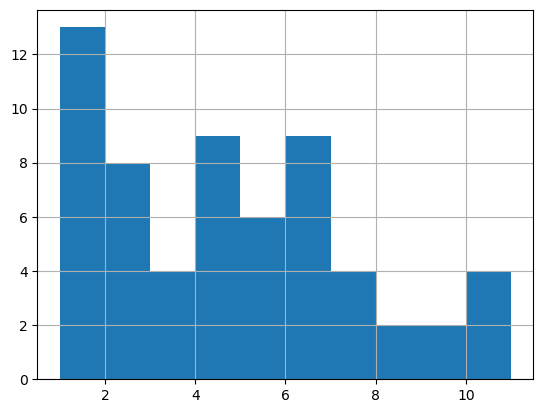

In [ ]:
training_sc_data.groupby("Metadata_Gene")["Mitocheck_Phenotypic_Class"].nunique().hist()

In [ ]:
# training_sc_data = pd.read_parquet("../data/processed/training_sc_data.parquet")
# neg_control_sc_data = pd.read_parquet("../data/processed/neg_control_sc_data.parquet")
training_sc_data = pd.read_csv(training_singlecell_data).drop("Unnamed: 0", axis=1)
neg_control_sc_data = pd.read_csv(neg_control_data)

# adding the Mitocheck_Phenotypic_Class into the controls  and labels
neg_control_sc_data.insert(0, "Mitocheck_Phenotypic_Class", "neg_control")

# adding control labels into the dataset
training_sc_data.insert(1, "Metadata_is_control", 0)
neg_control_sc_data.insert(1, "Metadata_is_control", 1)

# droping column from trainign data since it does not exist in the controls
training_sc_data = training_sc_data.drop("Metadata_Object_Outline", axis=1)


print("control shape:", neg_control_sc_data.shape)
print("training shape:", training_sc_data.shape)

control shape: (779993, 1450)
training shape: (2894, 1450)


## Applying Pycytominer Selected features data

In [27]:
fs_ops = [
    'variance_threshold',
    'correlation_threshold',
    'drop_na_columns',
    'blocklist'
]

In [9]:
# applying cytominer feature selection trianing data
cp_cols = [
    colname for colname in training_sc_data.columns if colname.startswith("CP__")
]

# # extracting only CP features
train_meta, train_features = utils.split_data(training_sc_data, dataset="CP")
cp_data = pd.concat([train_meta, pd.DataFrame(train_features)], axis=1)
cp_data.columns = train_meta.columns.tolist() + cp_cols

# applying pycytominer feature select
# had to specify the feature names since the defaults did not match
pycytm_cp_training_feats_df = feature_select(cp_data, features=cp_cols)
pycytm_cp_training_feats_df = pycytm_cp_training_feats_df[
    [
        cols
        for cols in pycytm_cp_training_feats_df.columns.tolist()
        if cols.startswith("CP__")
    ]
]
del cp_data

# now update loaded dataset with pycytominer selected features to trainin dataset
# remove old CP features and added new pycytominer selected CP_features
training_sc_data = training_sc_data[
    [col for col in training_sc_data.columns.tolist() if not col.startswith("CP__")]
]
training_sc_data = pd.concat([training_sc_data, pycytm_cp_training_feats_df], axis=1)
print(f"{training_sc_data.shape=}")

training_sc_data.shape=(2894, 1433)


In [10]:
# applying cytominer feature selection negative control data
cp_cols = [
    colname for colname in neg_control_sc_data.columns if colname.startswith("CP__")
]

# extracting only CP features
neg_control_meta, neg_control_features = utils.split_data(
    neg_control_sc_data, dataset="CP"
)
cp_data = pd.concat([neg_control_meta, pd.DataFrame(neg_control_features)], axis=1)
cp_data.columns = neg_control_meta.columns.tolist() + cp_cols

# applying pycytominer feature select
# had to specify the feature names since the defaults did not match
pycytm_cp_training_feats_df = feature_select(cp_data, features=cp_cols)
pycytm_cp_training_feats_df = pycytm_cp_training_feats_df[
    [
        cols
        for cols in pycytm_cp_training_feats_df.columns.tolist()
        if cols.startswith("CP__")
    ]
]
del cp_data

# now update loaded dataset with pycytominer selected features to trainin dataset
# remove old CP features and added new pycytominer selected features
neg_control_sc_data = neg_control_sc_data[
    [col for col in neg_control_sc_data.columns.tolist() if not col.startswith("CP__")]
]
neg_control_sc_data = pd.concat(
    [neg_control_sc_data, pycytm_cp_training_feats_df], axis=1
)
print(f"{neg_control_sc_data.shape=}")

neg_control_sc_data.shape=(779993, 1395)


In [11]:
neg_control_sc_data_subset = neg_control_sc_data.sample(frac=0.005, random_state=0)
neg_control_sc_data_subset.to_parquet("../data/processed/neg_control_sc_fs_subset.parquet", index=False)
print(f"{neg_control_sc_data_subset.shape=}")
training_sc_data.to_parquet("../data/processed/training_sc_fs.parquet", index=False)
print(f"{training_sc_data.shape=}")

neg_control_sc_data_subset.shape=(3900, 1395)
training_sc_data.shape=(2894, 1433)


### mAP Pipeline Parameters

In [5]:
training_sc_data = pd.read_parquet("../data/processed/training_sc_fs.parquet")
neg_control_sc_data = pd.read_parquet("../data/processed/neg_control_sc_fs_subset.parquet")

training_sc_data["Metadata_control_index"] = -1
neg_control_sc_data["Metadata_control_index"] = neg_control_sc_data.index

print(training_sc_data.shape, neg_control_sc_data.shape)

(2894, 1434) (3900, 1396)


In [6]:
all([c for c in neg_control_sc_data.columns if c in training_sc_data.columns] == neg_control_sc_data.columns)
training_sc_data = training_sc_data[neg_control_sc_data.columns]

df = pd.concat([training_sc_data, neg_control_sc_data], axis=0)
df.shape

(6794, 1396)

In [7]:
assert all(df.filter(regex="^(?!CP__|DP__)").columns == df.filter(regex="^(?!CP__|DP__)").columns)

meta_features = df.filter(regex="^(?!CP__|DP__)").columns
cp_features = df.filter(regex="^(CP__)").columns
dp_features = df.filter(regex="^(DP__)").columns
cp_dp_features = cp_features.tolist() + dp_features.tolist()

print(len(meta_features), len(cp_features), len(dp_features), len(cp_dp_features))

14 102 1280 1382


In [8]:
data_config = {
    "cp": cp_features,
    "dp": dp_features,
    "cp_dp": cp_dp_features,
}

In [9]:
# pos_sameby = ["Mitocheck_Phenotypic_Class", "Metadata_control_index"]
# pos_diffby = []

# neg_sameby = []
# neg_diffby = ["Mitocheck_Phenotypic_Class", "Metadata_control_index"]

# null_size = 10000
# batch_size = 1000

# number of resampling
# n_resamples = 10

pair_config = {
    "pos_sameby": {"all": ["Mitocheck_Phenotypic_Class", "Metadata_control_index"], "any": []},
    "pos_diffby": {"all": [], "any": []},
    "neg_sameby": {"all": [], "any": []},
    "neg_diffby": {"all": ["Mitocheck_Phenotypic_Class", "Metadata_control_index"], "any": []},
}

map_config = {
    "mean_ap": {
        "null_size": 10000,
        "groupby_columns": ["Mitocheck_Phenotypic_Class"],
    },
}

In [10]:
map_result = calc_map(
    df=df,
    meta_features=meta_features,
    features=cp_features,
    pair_config=pair_config,
    map_config=map_config,
)


Calculating distances.


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]


Calculating metric: mean_ap


/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/17 [00:00<?, ?it/s]

/dgx1nas1/storage/data/akalinin/projects/copairs/src/copairs/compute.py:95: RuntimeWarning: invalid value encountered in divide
  ap = (pr_k * rel_k).sum(axis=1) / num_pos


(16, 7)


In [11]:
map_result

,Mitocheck_Phenotypic_Class,mAP,p_value,n_pos_pairs,n_total_pairs,-log10(mAP p-value),p < 0.05
0,ADCCM,0.570424,2.201927e-234,88.0,3988.0,15.65356,True
1,Anaphase,0.502697,2.112754e-221,83.0,3983.0,15.65356,True
2,Apoptosis,0.654466,0.000000e+00,275.0,4175.0,15.65356,True
3,Binuclear,0.152709,0.000000e+00,173.0,4073.0,15.65356,True
4,Elongated,0.729062,3.295679e-281,106.0,4006.0,15.65356,True
5,Folded,0.238368,5.651168e-137,52.0,3952.0,15.65356,True
6,Grape,0.395290,8.220594e-206,77.0,3977.0,15.65356,True
7,Hole,0.308579,2.186335e-299,113.0,4013.0,15.65356,True
8,Interphase,0.149057,0.000000e+00,418.0,4318.0,15.65356,True
9,Large,0.402586,7.748528e-196,76.0,3976.0,15.65356,True


In [18]:
map_results = []

for feature_type, features in data_config.items():
    ap_result = map.average_precision(
        df[meta_features],
        df[features[:100]].values,
        pos_sameby=["Mitocheck_Phenotypic_Class", "Metadata_control_index"],
        pos_diffby=[],
        # neg_sameby=["Metadata_Plate"],
        neg_sameby=[],
        neg_diffby=["Mitocheck_Phenotypic_Class", "Metadata_control_index"],
    ).query("Mitocheck_Phenotypic_Class != 'neg_control'").reset_index(drop=True)

    map_result = map.mean_average_precision(
            ap_result, ["Mitocheck_Phenotypic_Class"], null_size=10000, threshold=0.05, seed=0
    )
    
    map_result["features"] = feature_type
    map_results.append(map_result)

map_results_df = pd.concat(map_results).reset_index(drop=True)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]

/dgx1nas1/storage/data/akalinin/miniconda3/envs/map/lib/python3.12/site-packages/copairs/compute.py:110: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]

/dgx1nas1/storage/data/akalinin/miniconda3/envs/map/lib/python3.12/site-packages/copairs/compute.py:110: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]

/dgx1nas1/storage/data/akalinin/miniconda3/envs/map/lib/python3.12/site-packages/copairs/compute.py:110: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [23]:
map_results_df

,Mitocheck_Phenotypic_Class,mean_average_precision,p_value,corrected_p_value,below_p,below_corrected_p,features
0,ADCCM,0.572761,0.0001,0.0001,True,True,cp
1,Anaphase,0.500150,0.0001,0.0001,True,True,cp
2,Apoptosis,0.658835,0.0001,0.0001,True,True,cp
3,Binuclear,0.156262,0.0001,0.0001,True,True,cp
4,Elongated,0.719355,0.0001,0.0001,True,True,cp
5,Folded,0.246036,0.0001,0.0001,True,True,cp
6,Grape,0.386608,0.0001,0.0001,True,True,cp
7,Hole,0.298835,0.0001,0.0001,True,True,cp
8,Interphase,0.149955,0.0001,0.0001,True,True,cp
9,Large,0.421511,0.0001,0.0001,True,True,cp


In [20]:
tech_map_compare = map_results_df.query("features != 'cp_dp'").pivot(
    index="Mitocheck_Phenotypic_Class",
    columns="features",
    values="mean_average_precision"
).reset_index()

In [21]:
import seaborn as sns

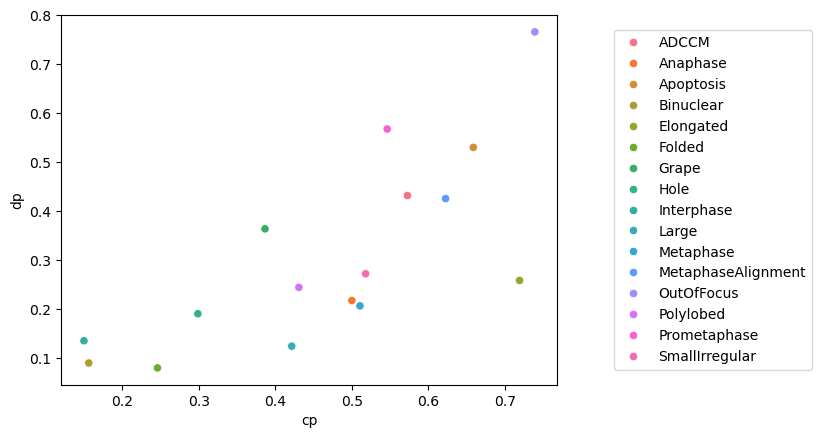

In [27]:
g = sns.scatterplot(tech_map_compare, x="cp", y="dp", hue="Mitocheck_Phenotypic_Class")
g.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)

In [8]:
ap_result = map.average_precision(
    df[meta_features],
    df[cp_features].values,
    pos_sameby=["Mitocheck_Phenotypic_Class", "Metadata_control_index"],
    pos_diffby=[],
    # neg_sameby=["Metadata_Plate"],
    neg_sameby=[],
    neg_diffby=["Mitocheck_Phenotypic_Class", "Metadata_control_index"],
).query("Mitocheck_Phenotypic_Class != 'neg_control'").reset_index(drop=True)

map_result = map.mean_average_precision(
        ap_result, ["Mitocheck_Phenotypic_Class"], null_size=10000, threshold=0.05, seed=0
)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]

/dgx1nas1/storage/data/akalinin/miniconda3/envs/map/lib/python3.12/site-packages/copairs/compute.py:110: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [9]:
map_result["features"] = "CP"
map_result

,Mitocheck_Phenotypic_Class,mean_average_precision,p_value,corrected_p_value,below_p,below_corrected_p,features
0,ADCCM,0.568623,0.0001,0.0001,True,True,CP
1,Anaphase,0.497724,0.0001,0.0001,True,True,CP
2,Apoptosis,0.658358,0.0001,0.0001,True,True,CP
3,Binuclear,0.155664,0.0001,0.0001,True,True,CP
4,Elongated,0.714324,0.0001,0.0001,True,True,CP
5,Folded,0.246021,0.0001,0.0001,True,True,CP
6,Grape,0.385644,0.0001,0.0001,True,True,CP
7,Hole,0.294037,0.0001,0.0001,True,True,CP
8,Interphase,0.149558,0.0001,0.0001,True,True,CP
9,Large,0.421420,0.0001,0.0001,True,True,CP


In [10]:
dp_ap_result = map.average_precision(
    df[meta_features],
    df[dp_features].values,
    pos_sameby=["Mitocheck_Phenotypic_Class", "Metadata_control_index"],
    pos_diffby=[],
    # neg_sameby=["Metadata_Plate"],
    neg_sameby=[],
    neg_diffby=["Mitocheck_Phenotypic_Class", "Metadata_control_index"],
).query("Mitocheck_Phenotypic_Class != 'neg_control'").reset_index(drop=True)

dp_map_result = map.mean_average_precision(
        dp_ap_result, ["Mitocheck_Phenotypic_Class"], null_size=10000, threshold=0.05, seed=0
)

dp_map_result["features"] = "DP"
dp_map_result

  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
cp_dp_ap_result = map.average_precision(
    df[meta_features],
    df[cp_dp_features].values,
    pos_sameby=["Mitocheck_Phenotypic_Class", "Metadata_control_index"],
    pos_diffby=[],
    # neg_sameby=["Metadata_Plate"],
    neg_sameby=[],
    neg_diffby=["Mitocheck_Phenotypic_Class", "Metadata_control_index"],
).query("Mitocheck_Phenotypic_Class != 'neg_control'").reset_index(drop=True)

cp_dp_map_result = map.mean_average_precision(
        cp_dp_ap_result, ["Mitocheck_Phenotypic_Class"], null_size=10000, threshold=0.05, seed=0
)

cp_dp_map_result["features"] = "CP_DP"
cp_dp_map_result

In [49]:
map_results = {}

for phenotype in training_sc_data["Mitocheck_Phenotypic_Class"].unique():
    phenotype_df = df.query("Mitocheck_Phenotypic_Class == @phenotype").reset_index(drop=True)
    for data_key, features in data_config.items():
        map_results[data_key] = calc_map(phenotype_df, meta_features, features, pair_config, map_config)


Calculating distances.


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [33]:
# storing all map results based on postiive and negative controls and feature types
logging.info("Running mAP pipeline with regular dataset")
map_results_neg_cp = []
map_results_neg_dp = []
map_results_neg_cp_dp = []

# running process
# for loop selects one single phenotype
# then splits the data into metadata and raw feature values
# two different groups that contains 3 splits caused by the types of features
# applie the copairs pipeline
for phenotype in list(training_sc_data["Mitocheck_Phenotypic_Class"].unique()):
    # select training dataset based on phenotype
    selected_training = training_sc_data.loc[
        training_sc_data["Mitocheck_Phenotypic_Class"] == phenotype
    ]
    n_entries_training = selected_training.shape[0]

    # This will generated 100 values [0..100] as seed values
    # This will occur per phenotype
    for seed in range(0, n_resamples):
        # concatenate to positive and negative control
        # selecting around 0.015% of the control data, that's around 117 cells
        training_w_neg = pd.concat(
            [
                selected_training,
                neg_control_sc_data.sample(frac=0.010, random_state=seed).iloc[
                    :n_entries_training
                ],
            ]
        )

        # spliting metadata and raw feature values
        logging.info("splitting data set into metadata and raw feature values")
        negative_training_cp_meta, negative_training_cp_feats = utils.split_data(
            training_w_neg, dataset="CP"
        )
        negative_training_dp_meta, negative_training_dp_feats = utils.split_data(
            training_w_neg, dataset="DP"
        )
        negative_training_cp_dp_meta, negative_training_cp_dp_feats = utils.split_data(
            training_w_neg, dataset="CP_and_DP"
        )

        break

        # placing under "try" block as some phenotype may raise "DivisionByZeroError"
        try:
            # execute pipeline on negative control with trianing dataset with cp features
            logging.info(f"Running pipeline on CP features using {phenotype} phenotype")

            feat_cols = [col for col in training_sc_data.columns if col not in negative_training_cp_meta.columns and not col.startswith("DP__")]
            cp_negative_training_result = calc_map(
                df=pd.concat([negative_training_cp_meta, pd.DataFrame(negative_training_cp_feats, columns=feat_cols)], axis=1).reset_index(drop=True),
                meta_features=negative_training_cp_meta.columns.tolist(),
                features=feat_cols,
                pair_config=pair_config,
                map_config=map_config
            )

            # cp_negative_training_result = run_pipeline(
            #     meta=negative_training_cp_meta,
            #     feats=negative_training_cp_feats,
            #     pos_sameby=pos_sameby,
            #     pos_diffby=pos_diffby,
            #     neg_sameby=neg_sameby,
            #     neg_diffby=neg_diffby,
            #     batch_size=batch_size,
            #     null_size=null_size,
            # )

            # adding columsn
            cp_negative_training_result["shuffled"] = "non-shuffled"
            cp_negative_training_result["seed_val"] = seed

            # append to list
            map_results_neg_cp.append(cp_negative_training_result)

            # execute pipeline on negative control with trianing dataset with dp features
            logging.info(f"Running pipeline on DP features using {phenotype} phenotype")

            feat_cols = [col for col in training_sc_data.columns if col not in negative_training_dp_meta.columns and not col.startswith("CP__")]
            dp_negative_training_result = calc_map(
                df=pd.concat([negative_training_dp_meta, pd.DataFrame(negative_training_dp_feats, columns=feat_cols)], axis=1).reset_index(drop=True),
                meta_features=negative_training_dp_meta.columns.tolist(),
                features=feat_cols,
                pair_config=pair_config,
                map_config=map_config
            )

            # dp_negative_training_result = run_pipeline(
            #     meta=negative_training_dp_meta,
            #     feats=negative_training_dp_feats,
            #     pos_sameby=pos_sameby,
            #     pos_diffby=pos_diffby,
            #     neg_sameby=neg_sameby,
            #     neg_diffby=neg_diffby,
            #     batch_size=batch_size,
            #     null_size=null_size,
            # )

            # adding shuffle label column
            dp_negative_training_result["shuffled"] = "non-shuffled"
            dp_negative_training_result["seed_val"] = seed

            # append to list
            map_results_neg_dp.append(dp_negative_training_result)

            # execute pipeline on negative control with trianing dataset with cp_dp features
            logging.info(
                f"Running pipeline on CP and DP features using {phenotype} phenotype"
            )

            feat_cols = [col for col in training_sc_data.columns if col not in negative_training_cp_dp_meta.columns]
            cp_dp_negative_training_result = calc_map(
                df=pd.concat([negative_training_cp_dp_meta, pd.DataFrame(negative_training_cp_dp_feats, columns=feat_cols)], axis=1).reset_index(drop=True),
                meta_features=negative_training_cp_dp_meta.columns.tolist(),
                features=feat_cols,
                pair_config=pair_config,
                map_config=map_config
            )

            # cp_dp_negative_training_result = run_pipeline(
            #     meta=negative_training_cp_dp_meta,
            #     feats=negative_training_cp_dp_feats,
            #     pos_sameby=pos_sameby,
            #     pos_diffby=pos_diffby,
            #     neg_sameby=neg_sameby,
            #     neg_diffby=neg_diffby,
            #     batch_size=batch_size,
            #     null_size=null_size,
            # )

            # adding shuffle label column
            cp_dp_negative_training_result["shuffled"] = "non-shuffled"
            cp_dp_negative_training_result["seed_val"] = seed

            # append to list
            map_results_neg_cp_dp.append(cp_dp_negative_training_result)
        except ZeroDivisionError as e:
            logging.warning(f"{e} captured on phenotye: {phenotype}. Skipping")
            continue


# concatenating all datasets
pd.concat(map_results_neg_cp).to_csv(
    map_out_dir / "cp_sc_mAP_scores_regular_negcon.csv", index=False
)
pd.concat(map_results_neg_dp).to_csv(
    map_out_dir / "dp_sc_mAP_scores_regular_negcon.csv", index=False
)
pd.concat(map_results_neg_cp_dp).to_csv(
    map_out_dir / "cp_dp_sc_mAP_scores_regular_negcon.csv", index=False
)

ValueError: No objects to concatenate

## Running mAP Pipeline on regular dataset

In [ ]:
# storing all map results based on postiive and negative controls and feature types
logging.info("Running mAP pipeline with regular dataset")
map_results_neg_cp = []
map_results_neg_dp = []
map_results_neg_cp_dp = []

# running process
# for loop selects one single phenotype
# then splits the data into metadata and raw feature values
# two different groups that contains 3 splits caused by the types of features
# applie the copairs pipeline
for phenotype in list(training_sc_data["Mitocheck_Phenotypic_Class"].unique()):
    # select training dataset based on phenotype
    selected_training = training_sc_data.loc[
        training_sc_data["Mitocheck_Phenotypic_Class"] == phenotype
    ]
    n_entries_training = selected_training.shape[0]

    # This will generated 100 values [0..100] as seed values
    # This will occur per phenotype
    for seed in range(0, n_resamples):
        # concatenate to positive and negative control
        # selecting around 0.015% of the control data, that's around 117 cells
        training_w_neg = pd.concat(
            [
                selected_training,
                neg_control_sc_data.sample(frac=0.010, random_state=seed).iloc[
                    :n_entries_training
                ],
            ]
        )

        # spliting metadata and raw feature values
        logging.info("splitting data set into metadata and raw feature values")
        negative_training_cp_meta, negative_training_cp_feats = utils.split_data(
            training_w_neg, dataset="CP"
        )
        negative_training_dp_meta, negative_training_dp_feats = utils.split_data(
            training_w_neg, dataset="DP"
        )
        negative_training_cp_dp_meta, negative_training_cp_dp_feats = utils.split_data(
            training_w_neg, dataset="CP_and_DP"
        )

        # placing under "try" block as some phenotype may raise "DivisionByZeroError"
        try:
            # execute pipeline on negative control with trianing dataset with cp features
            logging.info(f"Running pipeline on CP features using {phenotype} phenotype")
            cp_negative_training_result = run_pipeline(
                meta=negative_training_cp_meta,
                feats=negative_training_cp_feats,
                pos_sameby=pos_sameby,
                pos_diffby=pos_diffby,
                neg_sameby=neg_sameby,
                neg_diffby=neg_diffby,
                batch_size=batch_size,
                null_size=null_size,
            )

            # adding columsn
            cp_negative_training_result["shuffled"] = "non-shuffled"
            cp_negative_training_result["seed_val"] = seed

            # append to list
            map_results_neg_cp.append(cp_negative_training_result)

            # execute pipeline on negative control with trianing dataset with dp features
            logging.info(f"Running pipeline on DP features using {phenotype} phenotype")
            dp_negative_training_result = run_pipeline(
                meta=negative_training_dp_meta,
                feats=negative_training_dp_feats,
                pos_sameby=pos_sameby,
                pos_diffby=pos_diffby,
                neg_sameby=neg_sameby,
                neg_diffby=neg_diffby,
                batch_size=batch_size,
                null_size=null_size,
            )

            # adding shuffle label column
            dp_negative_training_result["shuffled"] = "non-shuffled"
            dp_negative_training_result["seed_val"] = seed

            # append to list
            map_results_neg_dp.append(dp_negative_training_result)

            # execute pipeline on negative control with trianing dataset with cp_dp features
            logging.info(
                f"Running pipeline on CP and DP features using {phenotype} phenotype"
            )
            cp_dp_negative_training_result = run_pipeline(
                meta=negative_training_cp_dp_meta,
                feats=negative_training_cp_dp_feats,
                pos_sameby=pos_sameby,
                pos_diffby=pos_diffby,
                neg_sameby=neg_sameby,
                neg_diffby=neg_diffby,
                batch_size=batch_size,
                null_size=null_size,
            )

            # adding shuffle label column
            cp_dp_negative_training_result["shuffled"] = "non-shuffled"
            cp_dp_negative_training_result["seed_val"] = seed

            # append to list
            map_results_neg_cp_dp.append(cp_dp_negative_training_result)
        except ZeroDivisionError as e:
            logging.warning(f"{e} captured on phenotye: {phenotype}. Skipping")
            continue


# concatenating all datasets
pd.concat(map_results_neg_cp).to_csv(
    map_out_dir / "cp_sc_mAP_scores_regular.csv", index=False
)
pd.concat(map_results_neg_dp).to_csv(
    map_out_dir / "dp_sc_mAP_scores_regular.csv", index=False
)
pd.concat(map_results_neg_cp_dp).to_csv(
    map_out_dir / "cp_dp_sc_mAP_scores_regular.csv", index=False
)

## Running MAP Pipeline with shuffled phenotype labels

In [ ]:
logging.info("Running mAP pipeline with shuffled phenotype labeled data")

# storing generated mAP pipline results seperated by feature
shuffled_labels_map_results_neg_cp = []
shuffled_labels_map_results_neg_dp = []
shuffled_labels_map_results_neg_cp_dp = []

# running process
# for loop selects one single phenotype
# then splits the data into metadata and raw feature values
# two different groups that contains 3 splits caused by the types of features
# applie the copairs pipeline
for phenotype in list(training_sc_data["Mitocheck_Phenotypic_Class"].unique()):
    # select training dataset based on phenotype
    logging.info(f"Phenotype selected: {phenotype}")
    selected_training = training_sc_data.loc[
        training_sc_data["Mitocheck_Phenotypic_Class"] == phenotype
    ]
    n_entries_training = selected_training.shape[0]

    # This will generated 100 values [0..100] as seed values
    # seed values will
    for seed in range(0, n_resamples):
        # setting seed
        logging.info(
            f"Running MAP Pipeline with shuffled data. Setting random seed too: {seed}"
        )
        np.random.seed(seed)

        # Below, we are running the same test, but we are shuffling the phenotypes
        logging.info(
            "Shuffling data based on the Mitocheck_Phenotypic_Class (phenotype) labels"
        )

        # concatenate to positive and negative control and shuffle labels
        training_w_neg = pd.concat(
            [
                selected_training,
                neg_control_sc_data.sample(frac=0.010, random_state=seed).iloc[
                    :n_entries_training
                ],
            ]
        )
        training_w_neg = shuffle_meta_labels(
            dataset=training_w_neg, target_col="Mitocheck_Phenotypic_Class", seed=seed
        )

        # splitting metadata labeled shuffled data
        logging.info("splitting shuffled data set into metadata and raw feature values")
        (
            shuffled_negative_training_cp_meta,
            shuffled_negative_training_cp_feats,
        ) = utils.split_data(training_w_neg, dataset="CP")
        (
            shuffled_negative_training_dp_meta,
            shuffled_negative_training_dp_feats,
        ) = utils.split_data(training_w_neg, dataset="DP")
        (
            shuffled_negative_training_cp_dp_meta,
            shuffled_negative_training_cp_dp_feats,
        ) = utils.split_data(training_w_neg, dataset="CP_and_DP")

        try:
            # execute pipeline on negative control with trianing dataset with cp features
            logging.info(
                f"Running pipeline on CP features using {phenotype} phenotype, data is shuffled by phenoptype labels"
            )
            shuffled_cp_negative_training_result = run_pipeline(
                meta=shuffled_negative_training_cp_meta,
                feats=shuffled_negative_training_cp_feats,
                pos_sameby=pos_sameby,
                pos_diffby=pos_diffby,
                neg_sameby=neg_sameby,
                neg_diffby=neg_diffby,
                batch_size=batch_size,
                null_size=null_size,
            )

            # adding shuffle label column
            shuffled_cp_negative_training_result["shuffled"] = "phenotype_shuffled"
            shuffled_cp_negative_training_result["seed_val"] = seed

            # append to list
            shuffled_labels_map_results_neg_cp.append(
                shuffled_cp_negative_training_result
            )

            # execute pipeline on negative control with trianing dataset with dp features
            logging.info(
                f"Running pipeline on DP features using {phenotype} phenotype, data is shuffled by phenoptype labels"
            )
            shuffled_dp_negative_training_result = run_pipeline(
                meta=shuffled_negative_training_dp_meta,
                feats=shuffled_negative_training_dp_feats,
                pos_sameby=pos_sameby,
                pos_diffby=pos_diffby,
                neg_sameby=neg_sameby,
                neg_diffby=neg_diffby,
                batch_size=batch_size,
                null_size=null_size,
            )

            # adding shuffle label column
            shuffled_dp_negative_training_result["shuffled"] = "phenotype_shuffled"
            shuffled_dp_negative_training_result["seed_val"] = seed

            # append to list
            shuffled_labels_map_results_neg_dp.append(
                shuffled_dp_negative_training_result
            )

            # execute pipeline on negative control with trianing dataset with cp_dp features
            logging.info(
                f"Running pipeline on CP and DP features using {phenotype} phenotype, data is shuffled by phenoptype labels"
            )
            shuffled_cp_dp_negative_training_result = run_pipeline(
                meta=shuffled_negative_training_cp_dp_meta,
                feats=shuffled_negative_training_cp_dp_feats,
                pos_sameby=pos_sameby,
                pos_diffby=pos_diffby,
                neg_sameby=neg_sameby,
                neg_diffby=neg_diffby,
                batch_size=batch_size,
                null_size=null_size,
            )

            # adding shuffle label column
            shuffled_cp_dp_negative_training_result["shuffled"] = "phenotype_shuffled"
            shuffled_cp_dp_negative_training_result["seed_val"] = seed

            # append to list
            shuffled_labels_map_results_neg_cp_dp.append(
                shuffled_cp_dp_negative_training_result
            )
        except ZeroDivisionError as e:
            logging.warning(f"{e} captured on phenotye: {phenotype}. Skipping")
            continue

# saving to csv
pd.concat(shuffled_labels_map_results_neg_cp).to_csv(
    map_out_dir / "cp_sc_mAP_scores_label_shuffled.csv", index=False
)
pd.concat(shuffled_labels_map_results_neg_dp).to_csv(
    map_out_dir / "dp_sc_mAP_scores_label_shuffled.csv", index=False
)
pd.concat(shuffled_labels_map_results_neg_cp_dp).to_csv(
    map_out_dir / "cp_dp_sc_mAP_scores_label_shuffled.csv", index=False
)

## Running MAP Pipeline with shuffled feature space 

In [ ]:
logging.info("Running mAP pipeline with shuffled feature space data")
shuffled_feat_map_results_neg_cp = []
shuffled_feat_map_results_neg_dp = []
shuffled_feat_map_results_neg_cp_dp = []

# running process
# for loop selects one single phenotype
# then splits the data into metadata and raw feature values
# two different groups that contains 3 splits caused by the types of features
# applie the copairs pipeline
for phenotype in list(training_sc_data["Mitocheck_Phenotypic_Class"].unique()):
    # select training dataset based on phenotype
    selected_training = training_sc_data.loc[
        training_sc_data["Mitocheck_Phenotypic_Class"] == phenotype
    ]
    n_entries_training = selected_training.shape[0]

    # This will generated 100 values [0..100] as seed values
    # seed values will
    for seed in range(0, n_resamples):
        # setting seed
        logging.info(
            f"Running MAP Pipeline with shuffled data. Setting random seed too: {seed}"
        )
        np.random.seed(seed)

        # Below, we are running the same test, but we are shuffling the phenotypes
        logging.info("Shuffling data based on the feature space")
        training_w_neg = pd.concat(
            [
                selected_training,
                neg_control_sc_data.sample(frac=0.010, random_state=seed).iloc[
                    :n_entries_training
                ],
            ]
        )

        # split the shuffled dataset
        # spliting metadata and raw feature values
        logging.info("splitting shuffled data set into metadata and raw feature values")
        (
            shuffled_negative_training_cp_meta,
            shuffled_negative_training_cp_feats,
        ) = utils.split_data(training_w_neg, dataset="CP")
        (
            shuffled_negative_training_dp_meta,
            shuffled_negative_training_dp_feats,
        ) = utils.split_data(training_w_neg, dataset="DP")
        (
            shuffled_negative_training_cp_dp_meta,
            shuffled_negative_training_cp_dp_feats,
        ) = utils.split_data(training_w_neg, dataset="CP_and_DP")

        # shuffling the features, this will overwrite the generated feature space from above with the shuffled one
        shuffled_negative_training_cp_feats = shuffle_features(
            feature_vals=shuffled_negative_training_cp_feats, seed=seed
        )
        shuffled_negative_training_dp_feats = shuffle_features(
            feature_vals=shuffled_negative_training_dp_feats, seed=seed
        )
        shuffled_negative_training_cp_dp_feats = shuffle_features(
            feature_vals=shuffled_negative_training_cp_dp_feats, seed=seed
        )

        try:
            # execute pipeline on negative control with trianing dataset with cp features
            logging.info(
                f"Running pipeline on CP features using {phenotype} phenotype, feature space is shuffled"
            )
            shuffled_cp_feat_negative_training_result = run_pipeline(
                meta=shuffled_negative_training_cp_meta,
                feats=shuffled_negative_training_cp_feats,
                pos_sameby=pos_sameby,
                pos_diffby=pos_diffby,
                neg_sameby=neg_sameby,
                neg_diffby=neg_diffby,
                batch_size=batch_size,
                null_size=null_size,
            )

            # adding shuffle label column
            shuffled_cp_feat_negative_training_result["shuffled"] = "features_shuffled"
            shuffled_cp_feat_negative_training_result["seed_val"] = seed

            # append to list
            shuffled_feat_map_results_neg_cp.append(
                shuffled_cp_feat_negative_training_result
            )

            # execute pipeline on negative control with trianing dataset with dp features
            logging.info(
                f"Running pipeline on DP features using {phenotype} phenotype, feature space is shuffled"
            )
            shuffled_dp_feat_negative_training_result = run_pipeline(
                meta=shuffled_negative_training_dp_meta,
                feats=shuffled_negative_training_dp_feats,
                pos_sameby=pos_sameby,
                pos_diffby=pos_diffby,
                neg_sameby=neg_sameby,
                neg_diffby=neg_diffby,
                batch_size=batch_size,
                null_size=null_size,
            )

            # adding shuffle label column
            shuffled_dp_feat_negative_training_result["shuffled"] = "features_shuffled"
            shuffled_dp_feat_negative_training_result["seed_val"] = seed

            # append to list
            shuffled_feat_map_results_neg_dp.append(
                shuffled_dp_feat_negative_training_result
            )

            # execute pipeline on negative control with trianing dataset with cp_dp features
            logging.info(
                f"Running pipeline on CP and DP features using {phenotype} phenotype, feature space is shuffled"
            )
            shuffled_cp_dp_feat_negative_training_result = run_pipeline(
                meta=shuffled_negative_training_cp_dp_meta,
                feats=shuffled_negative_training_cp_dp_feats,
                pos_sameby=pos_sameby,
                pos_diffby=pos_diffby,
                neg_sameby=neg_sameby,
                neg_diffby=neg_diffby,
                batch_size=batch_size,
                null_size=null_size,
            )

            # adding shuffle label column
            shuffled_cp_dp_feat_negative_training_result[
                "shuffled"
            ] = "features_shuffled"
            shuffled_cp_dp_feat_negative_training_result["seed_val"] = seed

            # append to list
            shuffled_feat_map_results_neg_cp_dp.append(
                shuffled_cp_dp_feat_negative_training_result
            )
        except ZeroDivisionError as e:
            logging.warning(f"{e} captured on phenotype: {phenotype}. Skipping")
            continue


# saving to csv
pd.concat(shuffled_feat_map_results_neg_cp).to_csv(
    map_out_dir / "cp_sc_mAP_scores_feat_shuffled.csv", index=False
)
pd.concat(shuffled_feat_map_results_neg_dp).to_csv(
    map_out_dir / "dp_sc_mAP_scores_feat_shuffled.csv", index=False
)
pd.concat(shuffled_feat_map_results_neg_cp_dp).to_csv(
    map_out_dir / "cp_dp_sc_mAP_scores_feat_shuffled.csv", index=False
)